In [3]:
# Author: Liam Collins
# We used the notebook of Liam Collins ("Exploiting Shared Representations for Personalized Federated Learning")[FedRep], but modified it and added FedSOUL

import numpy as np
import random
import matplotlib
from matplotlib import colors, pyplot as plt


import sys
sys.path.insert(0, '../')
from src.utils import pretty_matplotlib_config

In [4]:
pretty_matplotlib_config(fontsize=17)

### Generate data

In [5]:
dict_results = {}

In [30]:
def fix_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
seed = 16
fix_seed(seed)

In [31]:
d = 20 # k in paper
k = 2 # d in paper
n = 100 # b in paper
m = 10 # 10, 50
n_clients_with_min_datasets = 90
min_dataset_size_per_user = 2

m_test = 100
n_test = n
sigma2 = 0.1 # 0.001 # 0.1
T = 500
r = 1

Ystar = np.random.normal(size=(d, k))
Vstar, R = np.linalg.qr(Ystar)
VstarT = Vstar.T

Xstar = np.random.normal(size=(n, k))
Ustar, R = np.linalg.qr(Xstar)
for i in range(n):
    Ustar[i, :] = Ustar[i, :] / np.linalg.norm(Ustar[i, :])

Mstar = np.dot(Ustar, Vstar.T)

Xstar = np.random.normal(size=(n_test, k))
Ustar_test, R = np.linalg.qr(Xstar)
Mstar_test = np.dot(Ustar_test, Vstar.T)

I = np.eye(d)
A = np.zeros((n, m, d))
A_test = np.zeros((n_test, m_test, d))
Y = np.zeros((n, m))
Y_test = np.zeros((n_test, m_test))
for i in range(n):
    if i < n_clients_with_min_datasets:
        current_data_size = min_dataset_size_per_user
    else:
        current_data_size = m
    # train data
    for j in range(current_data_size):
        A[i, j, :] = np.random.normal(size=(d)) / (np.sqrt(current_data_size))
        Y[i, j] = np.dot(Mstar[i, :], A[i, j, :]) + np.random.normal(0, sigma2)
    # test data
for i in range(n_test):
    for j in range(m_test):
        A_test[i, j, :] = np.random.normal(size=(d)) / (np.sqrt(m_test))
        Y_test[i, j] = np.dot(Mstar[i, :], A_test[i, j, :]) + np.random.normal(0, sigma2)

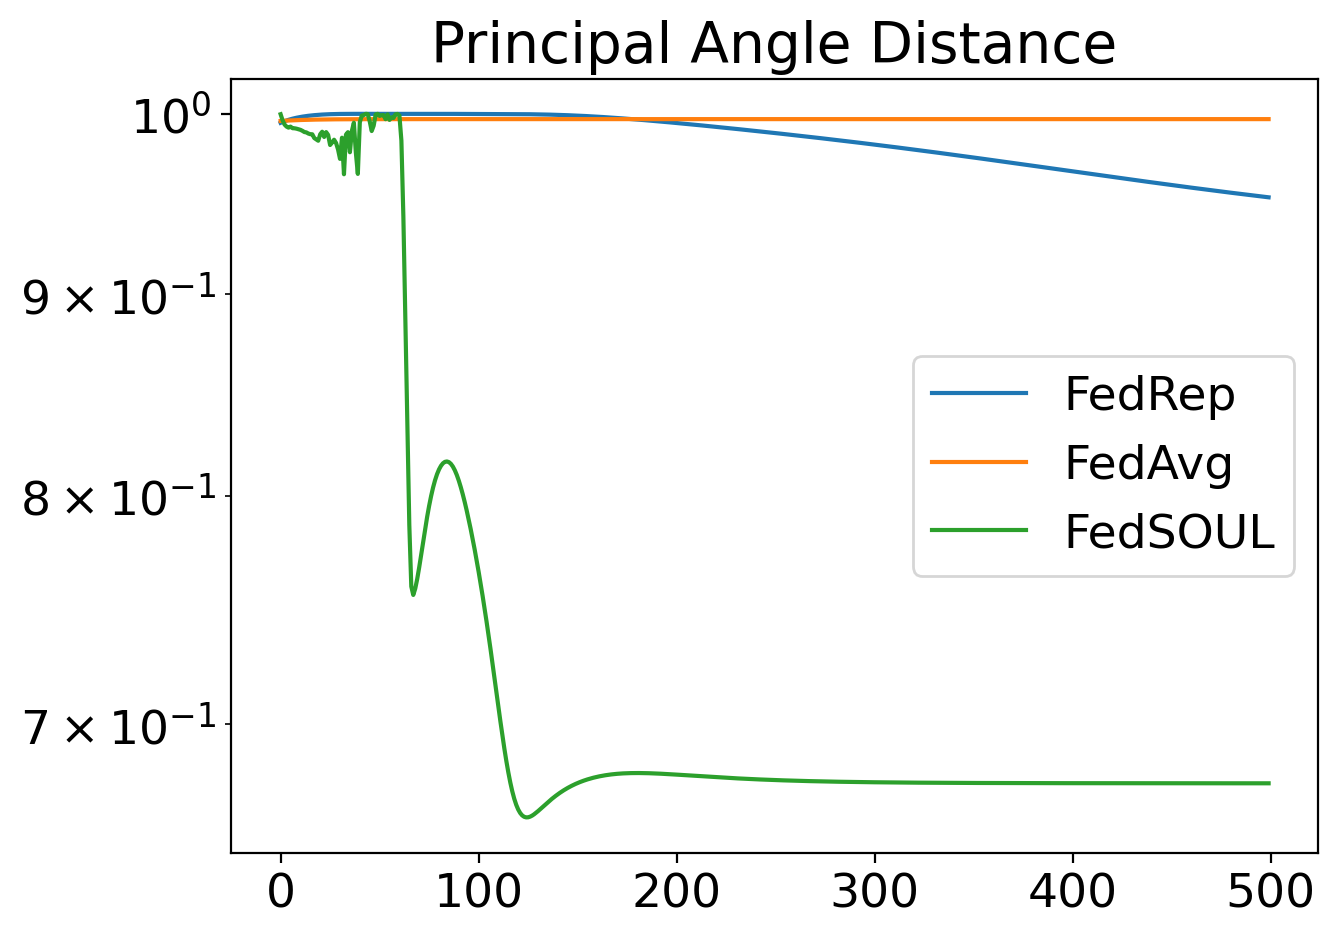

In [32]:
V_fedrep = np.random.normal(size=(d, k))
U_fedrep = np.random.normal(size=(n, k))

V_fedsgd = np.random.normal(size=(d, k))
u_fedsgd = np.random.normal(size=(k, 1))

V_fedsoul = np.random.normal(size=(d, k))
U_fedsoul = np.random.normal(size=(n, k))
beta_mu = np.random.normal(size=(k, 1))
beta_s_raw = np.ones(shape=(k, 1)) * np.log(np.exp(1) - 1)
raw_to_std_func = lambda x: np.log(1 + np.exp(x))
sigmoid = lambda x: 1 / (1 + np.exp(-x))




# alpha = 3.5/2
# beta = 0.01/2
eta_fedrep = 0.1  #25

eta_fedsgd = 0.01

eta_fedsoul = 0.05
eta_fedsoul_beta_mu = 0.005
eta_fedsoul_beta_s_raw = 0.05

dist_fedrep = np.zeros(T)
dist_fedsgd = np.zeros(T)
dist_fedsoul = np.zeros(T)

rn = r * n
spreads = np.zeros(T)

for t in range(T):

    clients = np.random.choice(n, max(1, int(rn)), replace=False)

    V_fedrep_orth, RVorth = np.linalg.qr(V_fedrep)
    V_fedsgd_orth, RVorth = np.linalg.qr(V_fedsgd)
    V_fedsoul_orth, RVorth = np.linalg.qr(V_fedsoul)

    dist_fedrep[t] = np.linalg.norm(np.dot((np.eye(d) - np.dot(V_fedrep_orth, V_fedrep_orth.T)), Vstar), ord=2) ** 2
    dist_fedsgd[t] = np.linalg.norm(np.dot((np.eye(d) - np.dot(V_fedsgd_orth, V_fedsgd_orth.T)), Vstar), ord=2) ** 2
    dist_fedsoul[t] = np.linalg.norm(np.dot((np.eye(d) - np.dot(V_fedsoul_orth, V_fedsoul_orth.T)), Vstar), ord=2) ** 2

    GV_fr = np.zeros((d, k))
    
    GV = np.zeros((d, k))
    Gu = np.zeros((k, 1))
    
    GV_fedsoul = np.zeros((d, k))
    Gbeta_mu = np.zeros((k, 1)) 
    Gbeta_s_raw = np.zeros((k, 1))
    
    for i in clients:
        if i < n_clients_with_min_datasets:
            current_data_size = min_dataset_size_per_user
        else:
            current_data_size = m
            
        Xi = A[i, :current_data_size, :] # batch of size current_data_size [current_data_size x d]
        # For FerRep and FedSGD
        wi = np.dot(np.linalg.inv(np.dot(np.dot(Xi, V_fedrep).T, np.dot(Xi, V_fedrep))),
                    np.dot(np.dot(Xi, V_fedrep).T, Y[i, :current_data_size].T)) # linear regression solution
        
        # For FedSOUL
        wi_fedsoul = np.dot(np.linalg.inv(np.dot(np.dot(Xi, V_fedsoul).T, np.dot(Xi, V_fedsoul)) + np.diag(1 / raw_to_std_func(beta_s_raw.squeeze()))),
                    np.dot(np.dot(Xi, V_fedsoul).T, Y[i, :current_data_size].T) + (1 / raw_to_std_func(beta_s_raw)).squeeze() * beta_mu.squeeze()) # regularized linear regression solution
        
        U_fedrep[i, :] = wi.T
        U_fedsoul[i, :] = wi_fedsoul.squeeze().T
        
        Sigma_i = np.dot(Xi.T, Xi)
        
        # FedRep
        GV_fr += np.dot(np.dot(Sigma_i, V_fedrep), np.outer(U_fedrep[i, :], U_fedrep[i, :])) - np.outer(
            np.dot(Xi.T, Y[i, :current_data_size]), U_fedrep[i, :])  # + eta_fedrep*np.outer(np.dot(Xi.T, Y[i,:]), U_fedrep[i,:])
        
        # FedSOUL
        Gbeta_mu += (1 / raw_to_std_func(beta_s_raw.reshape(k, 1))) * (beta_mu.squeeze() - wi_fedsoul.T).reshape(k, 1)
        Gbeta_s_raw += -(1 / raw_to_std_func(beta_s_raw.reshape(k, 1)))**2 * (beta_mu.squeeze() - wi_fedsoul.T).reshape(k, 1) * sigmoid(beta_s_raw)
        
        GV_fedsoul += np.dot(np.dot(Sigma_i, V_fedsoul), np.outer(U_fedsoul[i, :], U_fedsoul[i, :])) - np.outer(
            np.dot(Xi.T, Y[i, :current_data_size]), U_fedsoul[i, :])
        
        # FedSGD
        Gu += (np.dot(np.dot(V_fedsgd.T, Sigma_i), np.dot(V_fedsgd, u_fedsgd)) - np.expand_dims(
            np.dot(V_fedsgd.T, np.dot(Xi.T, Y[i, :current_data_size])), axis=-1)) / len(clients)
        
        GV += np.dot(V_fedsgd, np.outer(u_fedsgd, u_fedsgd)) - np.outer(np.dot(Xi.T, Y[i, :current_data_size]), u_fedsgd)

    V_fedrep = V_fedrep - eta_fedrep * GV_fr
    V_fedsgd = V_fedsgd - eta_fedsgd * GV
    u_fedsgd = u_fedsgd - eta_fedsgd * Gu
    
    beta_mu = beta_mu - eta_fedsoul_beta_mu * (beta_mu + Gbeta_mu)
    beta_s_raw = beta_s_raw - eta_fedsoul_beta_s_raw * (beta_s_raw + Gbeta_s_raw)
    V_fedsoul = V_fedsoul - eta_fedsoul * (V_fedsoul + GV_fedsoul)
    

e_local_fin = 0
e_fedrep_fin = 0
e_fedsgd_fin = 0
e_fedsoul_fin = 0
for i in range(n):
    if i < n_clients_with_min_datasets:
        current_data_size = min_dataset_size_per_user
    else:
        current_data_size = m
    Xi = A[i, :current_data_size, :]
    wi = np.dot(np.linalg.inv(np.dot(Xi.T, Xi) + 0.00001 * np.eye(d)), np.dot(Xi.T, Y[i, :current_data_size].T))
    ui = np.dot(np.linalg.inv(np.dot(np.dot(V_fedsgd.T, Xi.T), np.dot(Xi, V_fedsgd)) + 0.00001 * np.eye(k)),
                np.dot(np.dot(V_fedsgd.T, Xi.T), Y[i, :current_data_size].T))
    for j in range(m_test):
        # FedRep author's comment:
        # Note that we mistakenly divided these errors by m_test for the figure in the paper even though
        # the variance of the data is already 1/m_test. The code here corrects for this, and qualitatively, the results
        # are the same, because the same incorrect scaling was applied to all methods.
        e_local_fin += (Y_test[i, j] - np.dot(A_test[i, j, :], wi)) ** 2 / (2 * n)
        e_fedrep_fin += (Y_test[i, j] - np.dot(A_test[i, j, :], np.dot(V_fedrep, U_fedrep[i, :].T))) ** 2 / (2 * n)
        
        e_fedsoul_fin += (Y_test[i, j] - np.dot(A_test[i, j, :], np.dot(V_fedsoul, U_fedsoul[i, :].T))) ** 2 / (2 * n)
        
        e_fedsgd_fin += (Y_test[i, j] - np.dot(A_test[i, j, :], np.dot(V_fedsgd, ui))) ** 2 / (2 * n)

plt.figure(2, figsize=(7, 5), dpi=200)
plt.title('Principal Angle Distance')
plt.plot(dist_fedrep, label='FedRep')
plt.plot(dist_fedsgd, label='FedAvg')
plt.plot(dist_fedsoul, label='FedSOUL')
plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig(f"./toy_principle_angle_distance_{d=}_{k=}_{n=}_{n_clients_with_min_datasets=}.pdf", format="pdf")

plt.show();

current_res = {}
current_res["dist_fedrep"] = dist_fedrep
current_res["dist_fedsgd"] = dist_fedsgd
current_res["dist_fedsoul"] = dist_fedsoul

In [33]:
# FedRep
np.linalg.norm(Ustar_test - U_fedrep)

10.686511549075972

In [34]:
# FedSOUL
np.linalg.norm(Ustar_test - U_fedsoul)

3.257025247601895

In [35]:
# FedSGD
np.linalg.norm(Ustar_test - u_fedsgd.T.repeat(n, 0))

3.4928964547098786

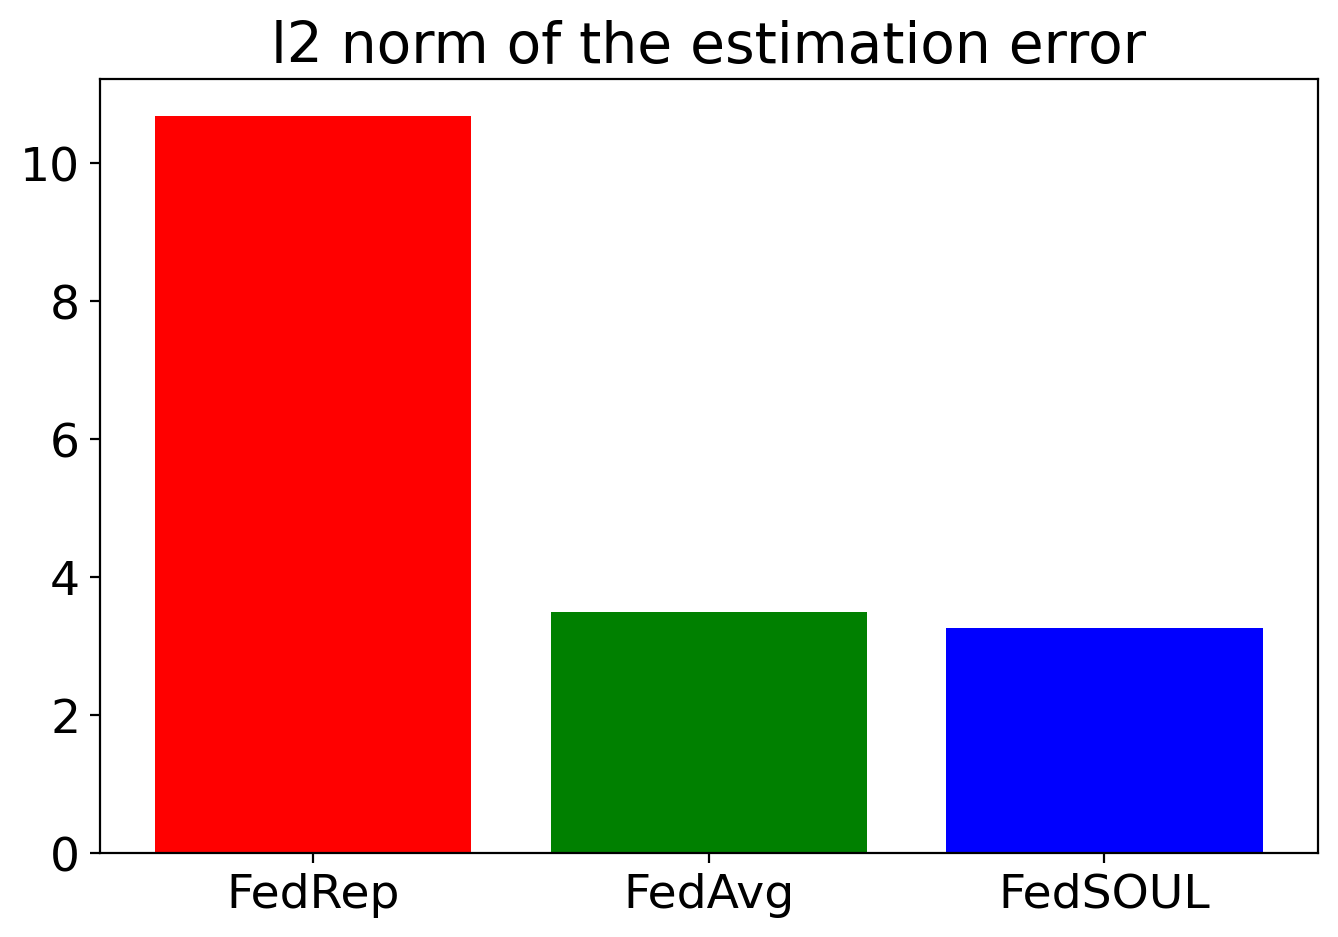

In [36]:
matplotlib.rcParams['text.usetex'] = False

plt.figure(2, figsize=(7, 5), dpi=200)
plt.title('l2 norm of the estimation error')

x = ["FedRep", "FedAvg", "FedSOUL"]
data = [
    np.linalg.norm(Ustar_test - U_fedrep),
    np.linalg.norm(Ustar_test - u_fedsgd.T.repeat(n, 0)),
    np.linalg.norm(Ustar_test - U_fedsoul),
]
color = ['red', 'green', 'blue']

plt.bar(x, data, color=color)
# plt.legend()
plt.tight_layout()
# plt.savefig(f"./toy_estimation_error_{d=}_{k=}_{n=}_{n_clients_with_min_datasets=}.pdf", format="pdf")

plt.show();

current_res["fedrep_norm"] = np.linalg.norm(Ustar_test - U_fedrep)
current_res["fedavg_norm"] = np.linalg.norm(Ustar_test - u_fedsgd.T.repeat(n, 0))
current_res["fedsoul_norm"] = np.linalg.norm(Ustar_test - U_fedsoul)

## If you want to average over different seeds, just run the next cell, and then go back to seed definition (above).

In [37]:
dict_results[seed] = current_res

In [38]:
## 

In [39]:
mean_fedrep = np.mean(np.concatenate([dict_results[s]["dist_fedrep"][None] for s in dict_results], axis=0), axis=0)
mean_fedsgd = np.mean(np.concatenate([dict_results[s]["dist_fedsgd"][None] for s in dict_results], axis=0), axis=0)
mean_fedsoul = np.mean(np.concatenate([dict_results[s]["dist_fedsoul"][None] for s in dict_results], axis=0), axis=0)

In [40]:
std_fedrep = np.std(np.concatenate([dict_results[s]["dist_fedrep"][None] for s in dict_results], axis=0), axis=0)
std_fedsgd = np.std(np.concatenate([dict_results[s]["dist_fedsgd"][None] for s in dict_results], axis=0), axis=0)
std_fedsoul = np.std(np.concatenate([dict_results[s]["dist_fedsoul"][None] for s in dict_results], axis=0), axis=0)

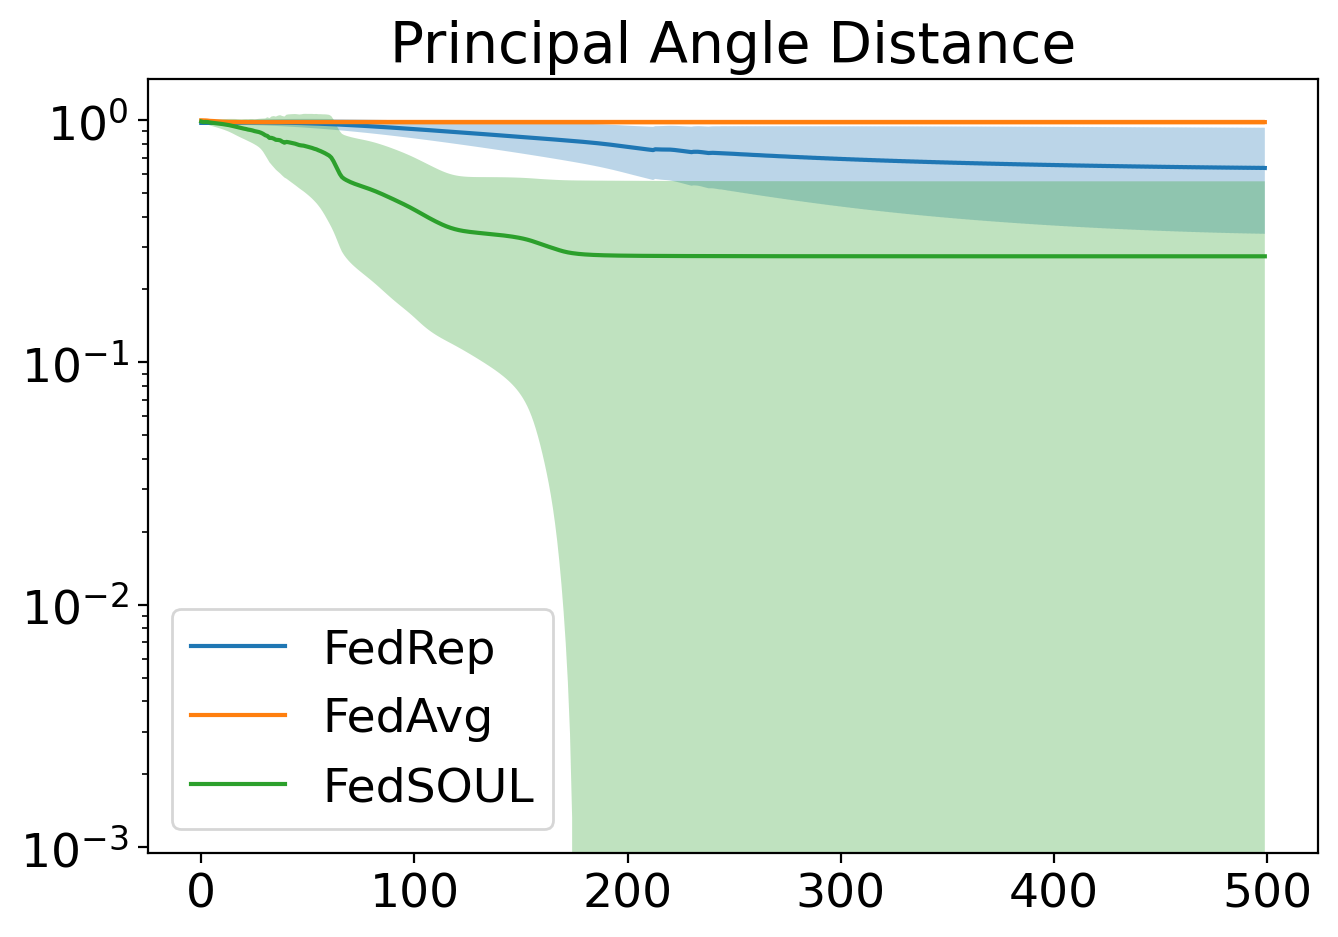

In [41]:
plt.figure(2, figsize=(7, 5), dpi=200)
plt.title('Principal Angle Distance')
plt.plot(mean_fedrep, label='FedRep')
plt.fill_between(np.arange(len(mean_fedrep)), y1=mean_fedrep - std_fedrep, y2=mean_fedrep + std_fedrep, alpha=0.3)

plt.plot(mean_fedsgd, label='FedAvg')
plt.fill_between(np.arange(len(mean_fedsgd)), y1=mean_fedsgd - std_fedsgd, y2=mean_fedsgd + std_fedsgd, alpha=0.3)

plt.plot(mean_fedsoul, label='FedSOUL')
plt.fill_between(np.arange(len(mean_fedsoul)), y1=mean_fedsoul - std_fedsoul, y2=mean_fedsoul + std_fedsoul, alpha=0.3)
plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig(f"./8_12_16_toy_principle_angle_distance_{d=}_{k=}_{n=}_{n_clients_with_min_datasets=}.pdf", format="pdf")

plt.show();

In [42]:
mean_norm_fedrep = np.mean(np.concatenate([dict_results[s]["fedrep_norm"][None] for s in dict_results], axis=0), axis=0)
mean_norm_fedsgd = np.mean(np.concatenate([dict_results[s]["fedavg_norm"][None] for s in dict_results], axis=0), axis=0)
mean_norm_fedsoul = np.mean(np.concatenate([dict_results[s]["fedsoul_norm"][None] for s in dict_results], axis=0), axis=0)

In [43]:
std_norm_fedrep = np.std(np.concatenate([dict_results[s]["fedrep_norm"][None] for s in dict_results], axis=0), axis=0)
std_norm_fedsgd = np.std(np.concatenate([dict_results[s]["fedavg_norm"][None] for s in dict_results], axis=0), axis=0)
std_norm_fedsoul = np.std(np.concatenate([dict_results[s]["fedsoul_norm"][None] for s in dict_results], axis=0), axis=0)

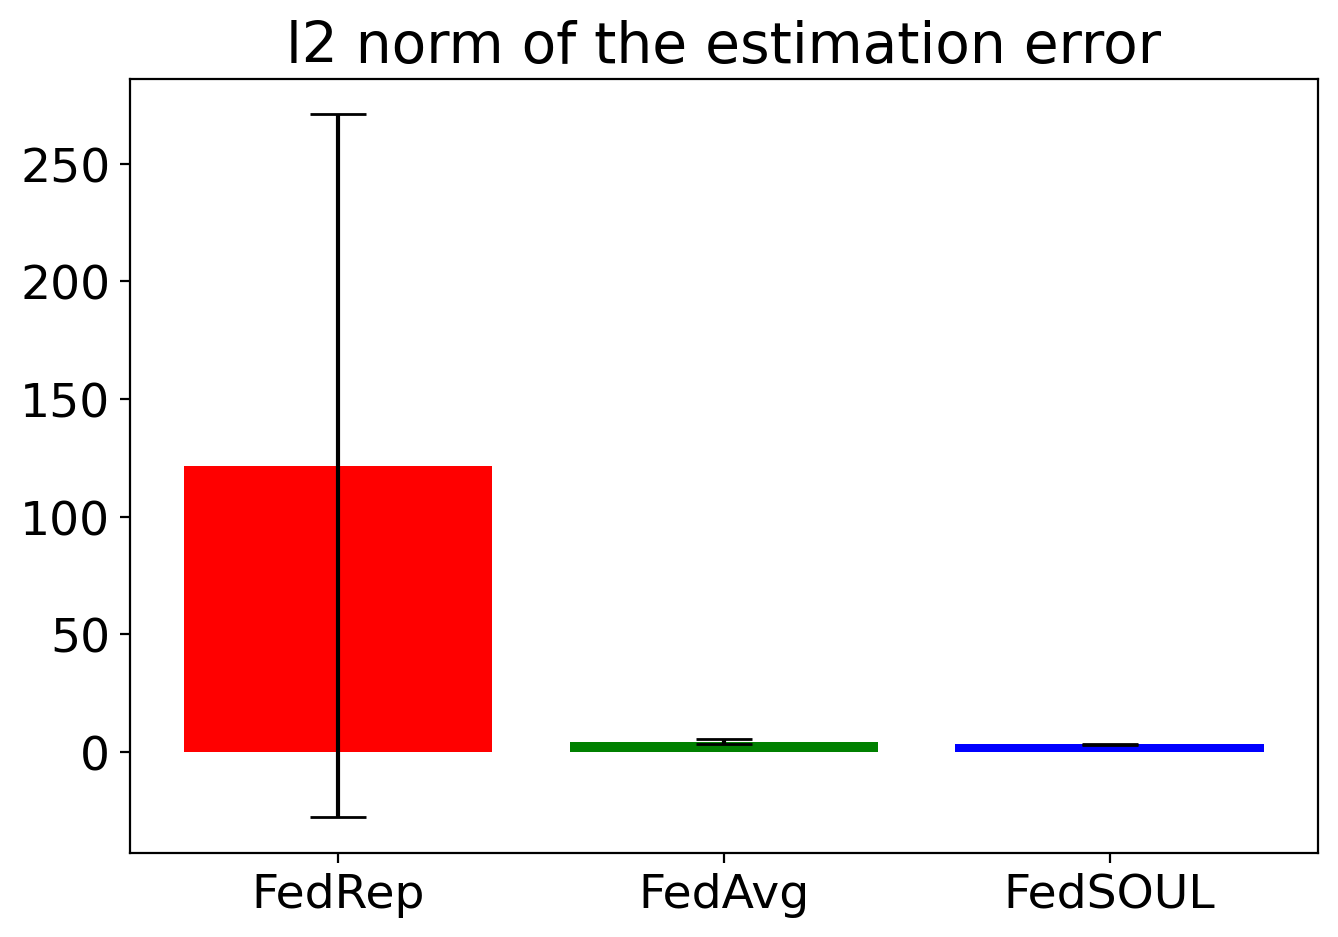

In [44]:
plt.figure(2, figsize=(7, 5), dpi=200)
plt.title('l2 norm of the estimation error')

x = ["FedRep", "FedAvg", "FedSOUL"]
data = [
    mean_norm_fedrep,
    mean_norm_fedsgd,
    mean_norm_fedsoul,
]
color = ['red', 'green', 'blue']

plt.bar(x, data, color=color, yerr=[std_norm_fedrep, std_norm_fedsgd, std_norm_fedsoul], ecolor='black', capsize=10)
# plt.legend()
plt.tight_layout()
# plt.savefig(f"./8_12_16_toy_estimation_error_{d=}_{k=}_{n=}_{n_clients_with_min_datasets=}.pdf", format="pdf")

plt.show();